In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle
cle.select_device('RTX')
print("Using OpenCL device " + cle.get_device().name)

import math
import numpy as np
import pandas as pd
import cv2
import tifffile
import os
import nrrd

from oiffile import OifFile
from src.OifImageViewer import OifImageViewer

Using OpenCL device NVIDIA RTX A5000


In [2]:
path = "/home/dkermany/data/Bone_Project/weijie_selected/main_folder/FV10__oibs/FV10__20190620_111343.oib"
filename = os.path.splitext(os.path.basename(path))[0]

with OifFile(path) as oif:
    viewer = OifImageViewer(oif)
    x_step, y_step, z_step = map(float, (viewer.md["x_step"], viewer.md["y_step"], viewer.md["z_step"]))
    if viewer.md["z_unit"] == "nm":
        z_step /= 1000.

Image shape: (3, 76, 2404, 3376)
Axes: CZYX
Dtype: uint16
Intervals: X (1.242um) Y (1.242um) Z (2660nm)



Load 3D Masks
----------------------

(76, 2404, 3376)
uint16


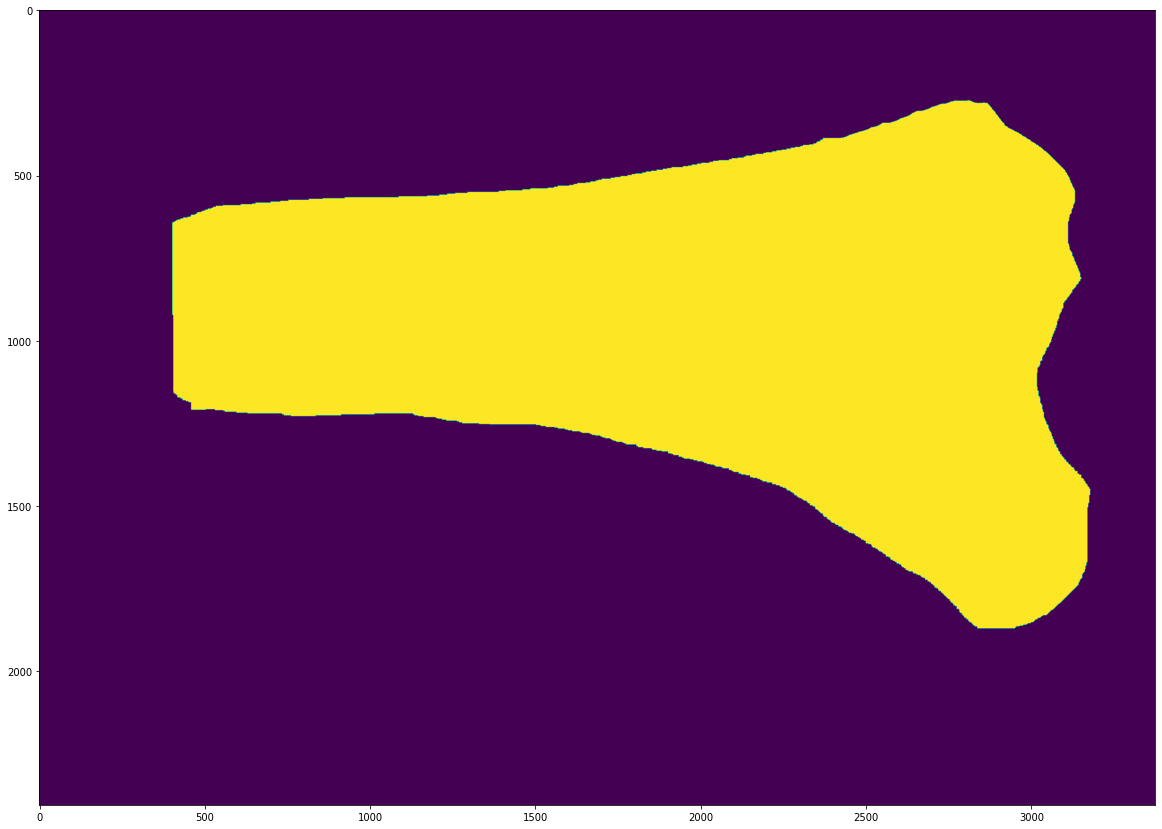

In [3]:
mask_path = "/home/dkermany/data/Bone_Project/masks/FV10__20190620_111343.seg.nrrd"

# Load mask from NRRD
mask, header = nrrd.read(mask_path)
mask = mask.T
mask = mask[:mask.shape[0]//3, :, :]

# Convert mask from uint8 to uint16
mask = mask.astype(np.uint16)
mask *= 2**16 - 1
print(mask.shape)
print(mask.dtype)

plt.figure(figsize=(20,20))
plt.imshow(mask[40])

In [4]:
tumor_csv_path = "/home/dkermany/data/Bone_Project/tumor_locations_09062022.csv"
# Load csv and drop rows with N/A's
tumor_csv = pd.read_csv(tumor_csv_path).dropna()
tumor_csv

Filename x (um)  y (um)  z (slice)
0   FV10__20190620_111343   2987  1760.0       76.0
1   FV10__20190620_111343   2975  1755.0       76.0
2   FV10__20190620_111343   2953  1715.0       76.0
3   FV10__20190620_111343   3079  1680.0       76.0
4   FV10__20190620_111343   2815  1342.0       76.0
5   FV10__20190620_111343    907  1229.0       76.0
6   FV10__20190620_111343   3015   875.0       76.0
7   FV10__20190620_111343   3021   861.0       76.0
8   FV10__20190620_111343   3055   910.0       76.0
9   FV10__20190620_111343   3271  1044.0       76.0
10  FV10__20190620_111343   3323   746.0       76.0
11  FV10__20190620_111343   3442   739.0       76.0
12  FV10__20190620_111343   2876  1779.0       67.0
13  FV10__20190620_111343   2961   883.0       65.0
14  FV10__20190620_111343   2921   896.0       63.0
15  FV10__20190620_111343   3128   928.0       62.0
16  FV10__20190620_111343   2912  1391.0       60.0
17  FV10__20190620_111343   2859  1738.0       59.0
18  FV10__20190620_111343   2351   804.0       54.0
19  FV10__20190620_111343   2351   804.0       54.0
20  FV10__20190620_111343   2902  1760.0       52.0
21  FV10__20190620_111343   2920  1768.0       52.0
22  FV10__20190620_111343   3477   736.0       49.0
23  FV10__20190620_111343   2940  1731.0       44.0
24  FV10__20190620_111343   2412   852.0       43.0
25  FV10__20190620_111343   2995  1404.0       37.0
26  FV10__20190620_111343   2395   830.0       36.0
27  FV10__20190620_111343   2522  1608.0       27.0
28  FV10__20190620_111343   2151  1544.0       27.0
29  FV10__20190620_111343   1023   934.0       14.0
30  FV10__20190620_111343   2099  1523.0        5.0
31  FV10__20190620_111343   2786  1678.0        1.0
32  FV10__20190620_111343   2682  1685.0        1.0
33  FV10__20190620_111343   2682  1663.0        1.0
34  FV10__20190620_111343   3144  1832.0        1.0


Tumor Location Marking
----------------------

In [5]:
# Filter tumors for the image in focus
tumor_csv = tumor_csv[tumor_csv.Filename == filename]
tumor_csv

Filename x (um)  y (um)  z (slice)
0   FV10__20190620_111343   2987  1760.0       76.0
1   FV10__20190620_111343   2975  1755.0       76.0
2   FV10__20190620_111343   2953  1715.0       76.0
3   FV10__20190620_111343   3079  1680.0       76.0
4   FV10__20190620_111343   2815  1342.0       76.0
5   FV10__20190620_111343    907  1229.0       76.0
6   FV10__20190620_111343   3015   875.0       76.0
7   FV10__20190620_111343   3021   861.0       76.0
8   FV10__20190620_111343   3055   910.0       76.0
9   FV10__20190620_111343   3271  1044.0       76.0
10  FV10__20190620_111343   3323   746.0       76.0
11  FV10__20190620_111343   3442   739.0       76.0
12  FV10__20190620_111343   2876  1779.0       67.0
13  FV10__20190620_111343   2961   883.0       65.0
14  FV10__20190620_111343   2921   896.0       63.0
15  FV10__20190620_111343   3128   928.0       62.0
16  FV10__20190620_111343   2912  1391.0       60.0
17  FV10__20190620_111343   2859  1738.0       59.0
18  FV10__20190620_111343   2351   804.0       54.0
19  FV10__20190620_111343   2351   804.0       54.0
20  FV10__20190620_111343   2902  1760.0       52.0
21  FV10__20190620_111343   2920  1768.0       52.0
22  FV10__20190620_111343   3477   736.0       49.0
23  FV10__20190620_111343   2940  1731.0       44.0
24  FV10__20190620_111343   2412   852.0       43.0
25  FV10__20190620_111343   2995  1404.0       37.0
26  FV10__20190620_111343   2395   830.0       36.0
27  FV10__20190620_111343   2522  1608.0       27.0
28  FV10__20190620_111343   2151  1544.0       27.0
29  FV10__20190620_111343   1023   934.0       14.0
30  FV10__20190620_111343   2099  1523.0        5.0
31  FV10__20190620_111343   2786  1678.0        1.0
32  FV10__20190620_111343   2682  1685.0        1.0
33  FV10__20190620_111343   2682  1663.0        1.0
34  FV10__20190620_111343   3144  1832.0        1.0

In [6]:
tumor_dict = tumor_csv.to_dict("index")
tumor_dict

{0: {'Filename': 'FV10__20190620_111343',
  'x (um)': '2987',
  'y (um)': 1760.0,
  'z (slice)': 76.0},
 1: {'Filename': 'FV10__20190620_111343',
  'x (um)': '2975',
  'y (um)': 1755.0,
  'z (slice)': 76.0},
 2: {'Filename': 'FV10__20190620_111343',
  'x (um)': '2953',
  'y (um)': 1715.0,
  'z (slice)': 76.0},
 3: {'Filename': 'FV10__20190620_111343',
  'x (um)': '3079',
  'y (um)': 1680.0,
  'z (slice)': 76.0},
 4: {'Filename': 'FV10__20190620_111343',
  'x (um)': '2815',
  'y (um)': 1342.0,
  'z (slice)': 76.0},
 5: {'Filename': 'FV10__20190620_111343',
  'x (um)': '907',
  'y (um)': 1229.0,
  'z (slice)': 76.0},
 6: {'Filename': 'FV10__20190620_111343',
  'x (um)': '3015',
  'y (um)': 875.0,
  'z (slice)': 76.0},
 7: {'Filename': 'FV10__20190620_111343',
  'x (um)': '3021',
  'y (um)': 861.0,
  'z (slice)': 76.0},
 8: {'Filename': 'FV10__20190620_111343',
  'x (um)': '3055',
  'y (um)': 910.0,
  'z (slice)': 76.0},
 9: {'Filename': 'FV10__20190620_111343',
  'x (um)': '3271',
  'y (

In [7]:
tumor_labels = np.zeros(viewer._arr.shape[1:], dtype=np.uint16)

In [8]:
for idx, tumor_info in tumor_dict.items():
    x_um, y_um, z_slice = map(int, (tumor_info["x (um)"], tumor_info["y (um)"], tumor_info["z (slice)"]))
    x, y, z = map(int, (x_um / x_step, y_um / y_step, z_slice-1))
    print(x, y, z)
    
    sphere_radius = 7 # micron
    sphere_z_slices = math.ceil(sphere_radius / z_step)
    
    min_z_step = max(0, z-sphere_z_slices)
    max_z_step = min(z+sphere_z_slices, viewer._arr.shape[1])

    # Label tumor
    for z_prime in range(min_z_step, max_z_step):
        cv2.circle(
            tumor_labels[z_prime],
            (x, y),
            radius=round((sphere_radius**2 - min((z_step*abs(z_prime-z))**2, sphere_radius**2))**0.5),
            color=(4096,4096,4096),
            thickness=-1,
        )
print(tumor_labels.shape)

2404 1417 75
2395 1413 75
2377 1380 75
2479 1352 75
2266 1080 75
730 989 75
2427 704 75
2432 693 75
2459 732 75
2633 840 75
2675 600 75
2771 595 75
2315 1432 66
2384 710 64
2351 721 62
2518 747 61
2344 1119 59
2301 1399 58
1892 647 53
1892 647 53
2336 1417 51
2351 1423 51
2799 592 48
2367 1393 43
1942 685 42
2411 1130 36
1928 668 35
2030 1294 26
1731 1243 26
823 752 13
1690 1226 4
2243 1351 0
2159 1356 0
2159 1338 0
2531 1475 0
(76, 2404, 3376)


In [9]:
total_image = np.concatenate((viewer._arr, np.expand_dims(tumor_labels, axis=0)), axis=0)
print(total_image.shape)
print("Total Image type:", total_image.dtype)

(4, 76, 2404, 3376)
Total Image type: uint16


In [10]:
def dict_to_pointlist(dict: tumor_dict) -> np.ndarray:
    pointlist = np.zeros((3, len(tumor_dict)))
    for idx, tumor_info in tumor_dict.items():
        x_um, y_um, z_slice = map(int, (tumor_info["x (um)"], tumor_info["y (um)"], tumor_info["z (slice)"]))
        x, y, z = map(int, (x_um / x_step, y_um / y_step, z_slice-1))
        
        pointlist[0][idx] = x
        pointlist[1][idx] = y
        pointlist[2][idx] = z
        
    return pointlist

In [11]:
tumor_pointlist = dict_to_pointlist(tumor_dict)
print(tumor_pointlist)

[[2404. 2395. 2377. 2479. 2266.  730. 2427. 2432. 2459. 2633. 2675. 2771.
  2315. 2384. 2351. 2518. 2344. 2301. 1892. 1892. 2336. 2351. 2799. 2367.
  1942. 2411. 1928. 2030. 1731.  823. 1690. 2243. 2159. 2159. 2531.]
 [1417. 1413. 1380. 1352. 1080.  989.  704.  693.  732.  840.  600.  595.
  1432.  710.  721.  747. 1119. 1399.  647.  647. 1417. 1423.  592. 1393.
   685. 1130.  668. 1294. 1243.  752. 1226. 1351. 1356. 1338. 1475.]
 [  75.   75.   75.   75.   75.   75.   75.   75.   75.   75.   75.   75.
    66.   64.   62.   61.   59.   58.   53.   53.   51.   51.   48.   43.
    42.   36.   35.   26.   26.   13.    4.    0.    0.    0.    0.]]


Vessel Segmentation
-----------------------------

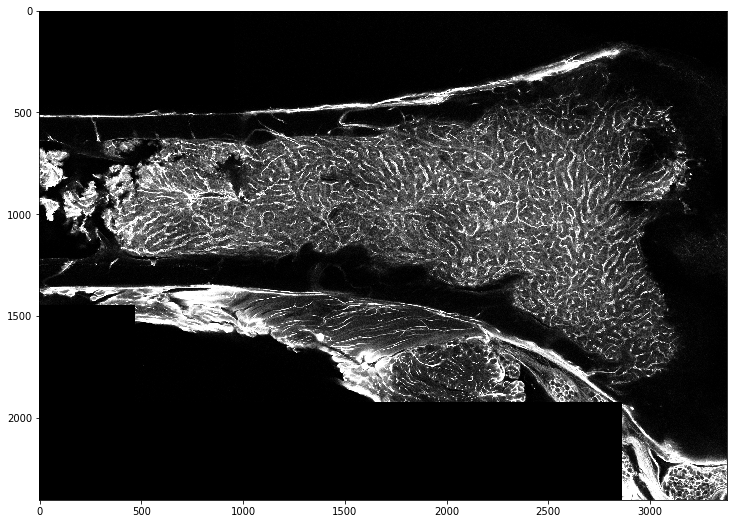

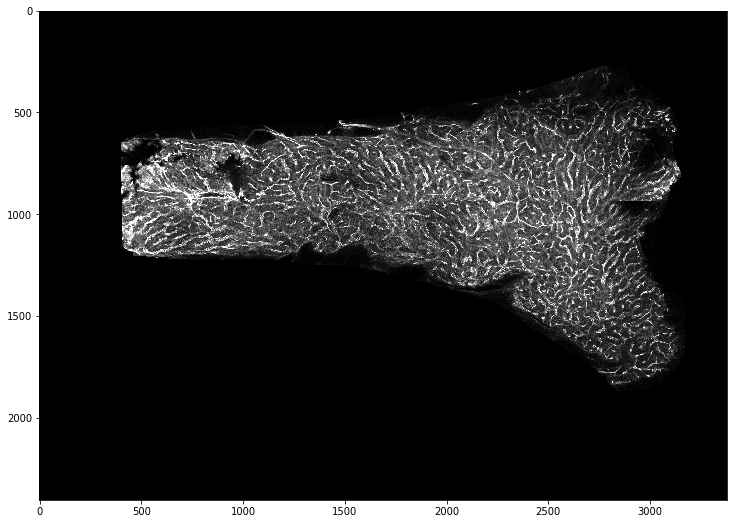

In [12]:
original_vessels = cle.push(viewer.get_array()[2])
plt.figure(figsize=(16,9))
cle.imshow(original_vessels[40])

masked_vessels = cle.mask(original_vessels, mask)
plt.figure(figsize=(16,9))
cle.imshow(masked_vessels[40])

del original_vessels

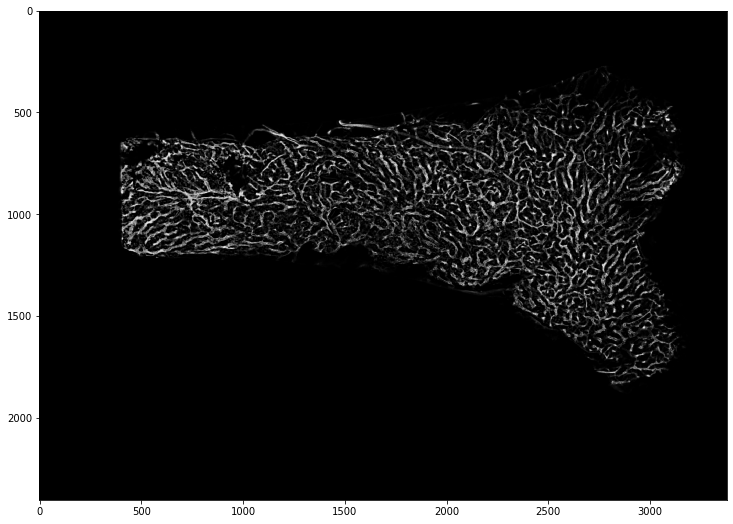

In [13]:
img_gaussian = cle.gaussian_blur(masked_vessels, sigma_x=2, sigma_y=2, sigma_z=2)
backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

plt.figure(figsize=(16,9))
cle.imshow(backgrund_subtracted[40])

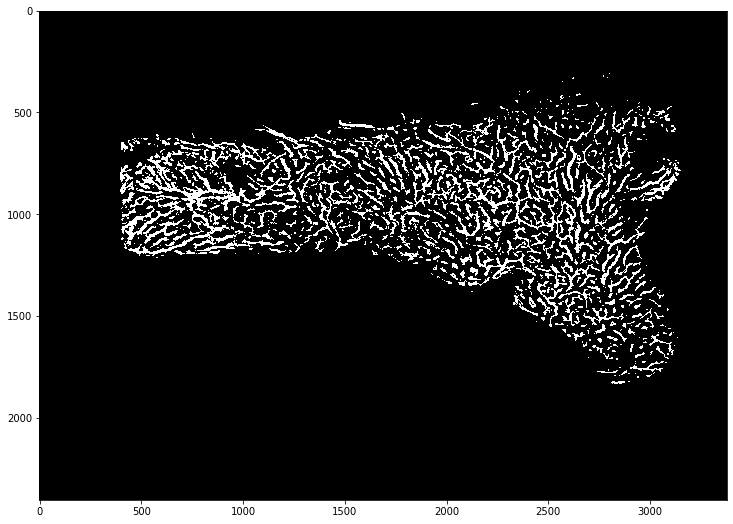

In [14]:
thresh2 = cle.threshold_otsu(backgrund_subtracted)

plt.figure(figsize=(16,9))
cle.imshow(thresh2[40])

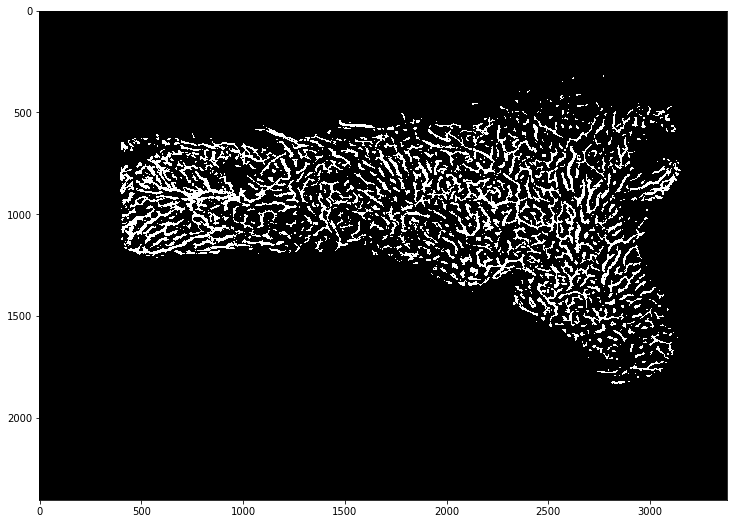

In [15]:
# Morphological openning
erosion = cle.erode_box(thresh2)
dilation = cle.dilate_box(erosion)

plt.figure(figsize=(16,9))
cle.imshow(dilation[40])

In [16]:
del erosion, backgrund_subtracted, img_gaussian

In [17]:
# Convert dilation from uint8 to uint16
dilation = dilation.astype(np.uint16)
dilation *= 2**10 - 1 #2**16 - 1

# Add vessel segmentation result to total_image
total_image = np.concatenate((total_image, np.expand_dims(cle.pull(dilation), axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

(5, 76, 2404, 3376)
uint16


Find Vessel Bifurcations
----

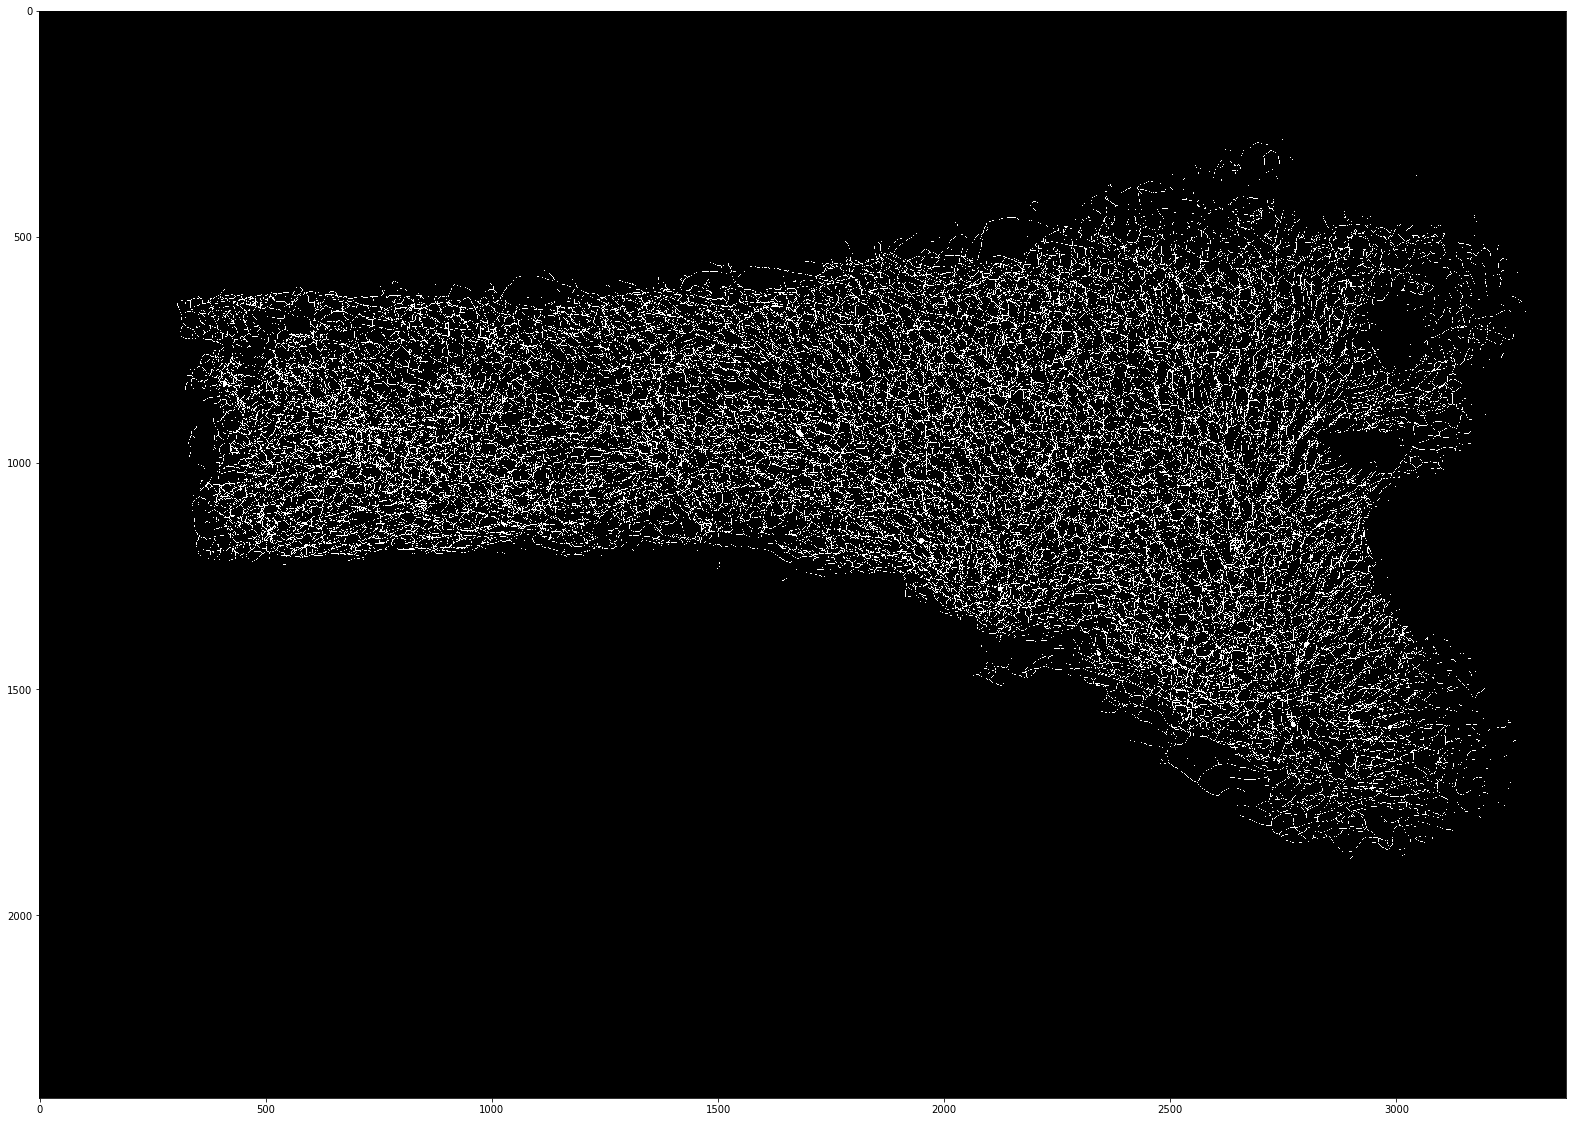

In [18]:
from skimage.morphology import skeletonize_3d
skeleton = skeletonize_3d(dilation)

plt.figure(figsize=(30,20))
cle.imshow(skeleton)

In [19]:
total_image = np.concatenate((total_image, np.expand_dims(cle.pull(skeleton), axis=0)), axis=0)
del skeleton

NG2 Segmentation
---------------------------

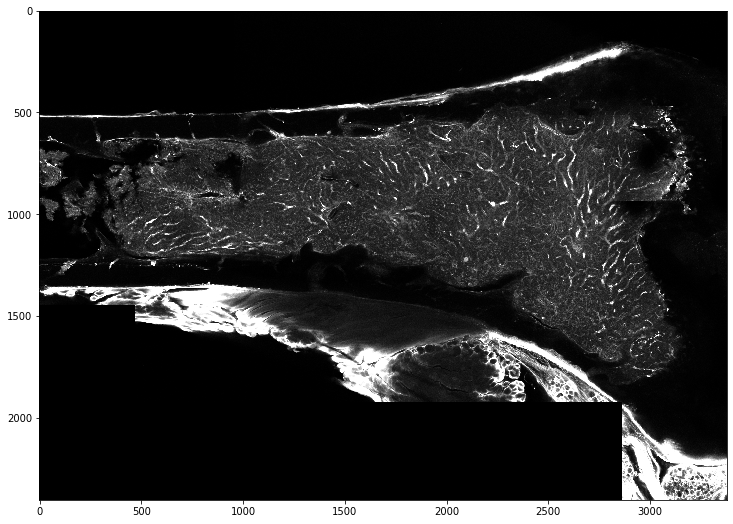

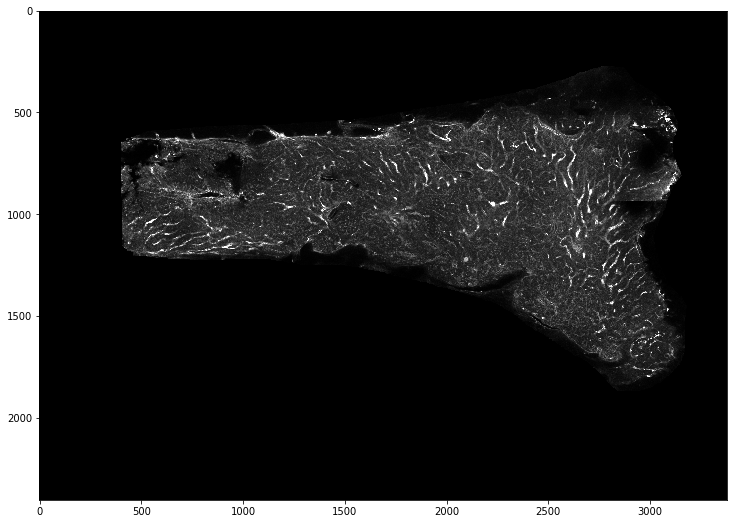

In [20]:
original_ng2 = cle.push(viewer.get_array()[1])
plt.figure(figsize=(16,9))
cle.imshow(original_ng2[40])

masked_ng2 = cle.mask(original_ng2, mask)
plt.figure(figsize=(16,9))
cle.imshow(masked_ng2[40])

del original_ng2

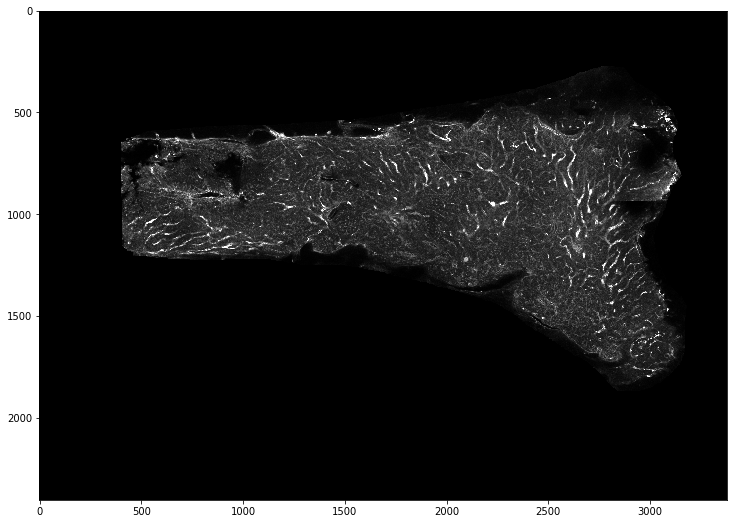

In [21]:


plt.figure(figsize=(16,9))
cle.imshow(masked_ng2[40])

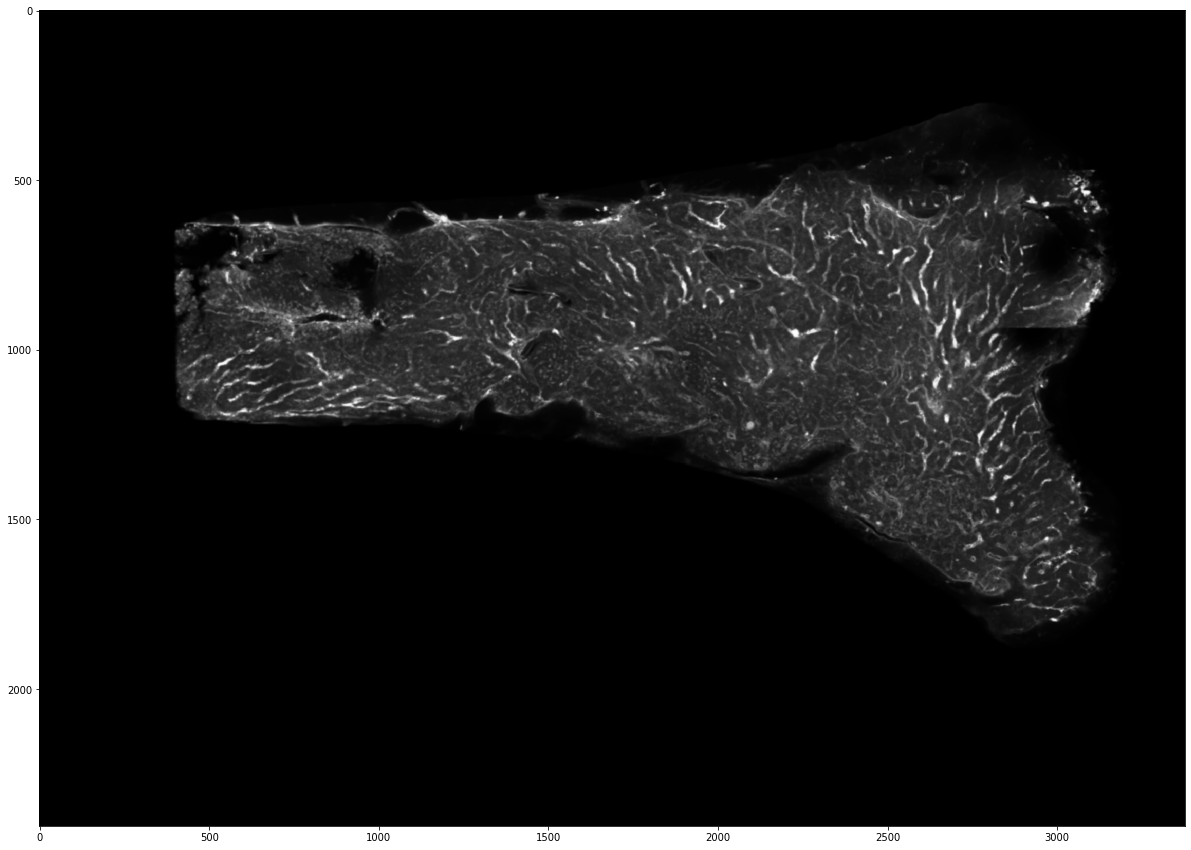

In [22]:
img_gaussian = cle.gaussian_blur(masked_ng2, sigma_x=2, sigma_y=2, sigma_z=2)
plt.figure(figsize=(30,15))
cle.imshow(img_gaussian[40])

del masked_ng2

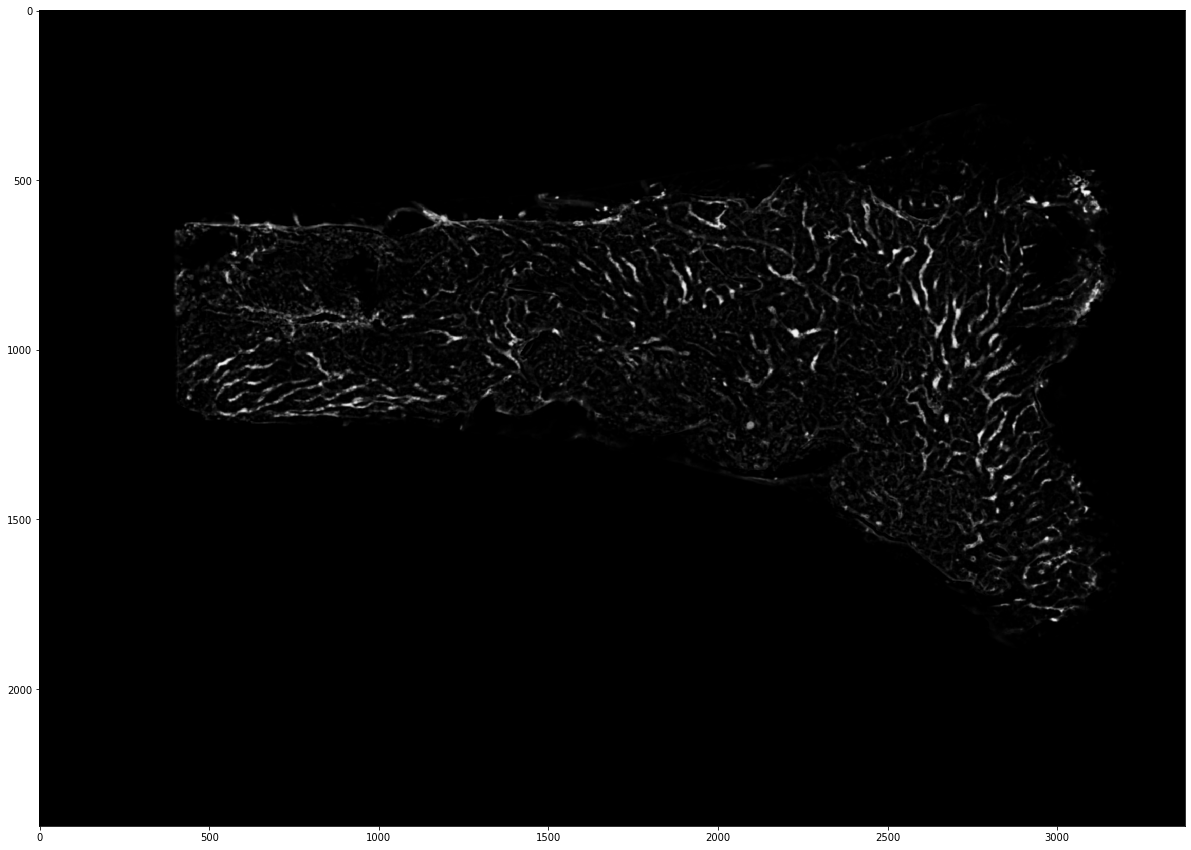

In [23]:
backgrund_subtracted = cle.top_hat_box(img_gaussian, radius_x=10, radius_y=10, radius_z=5)

plt.figure(figsize=(30,15))
cle.imshow(backgrund_subtracted[40])

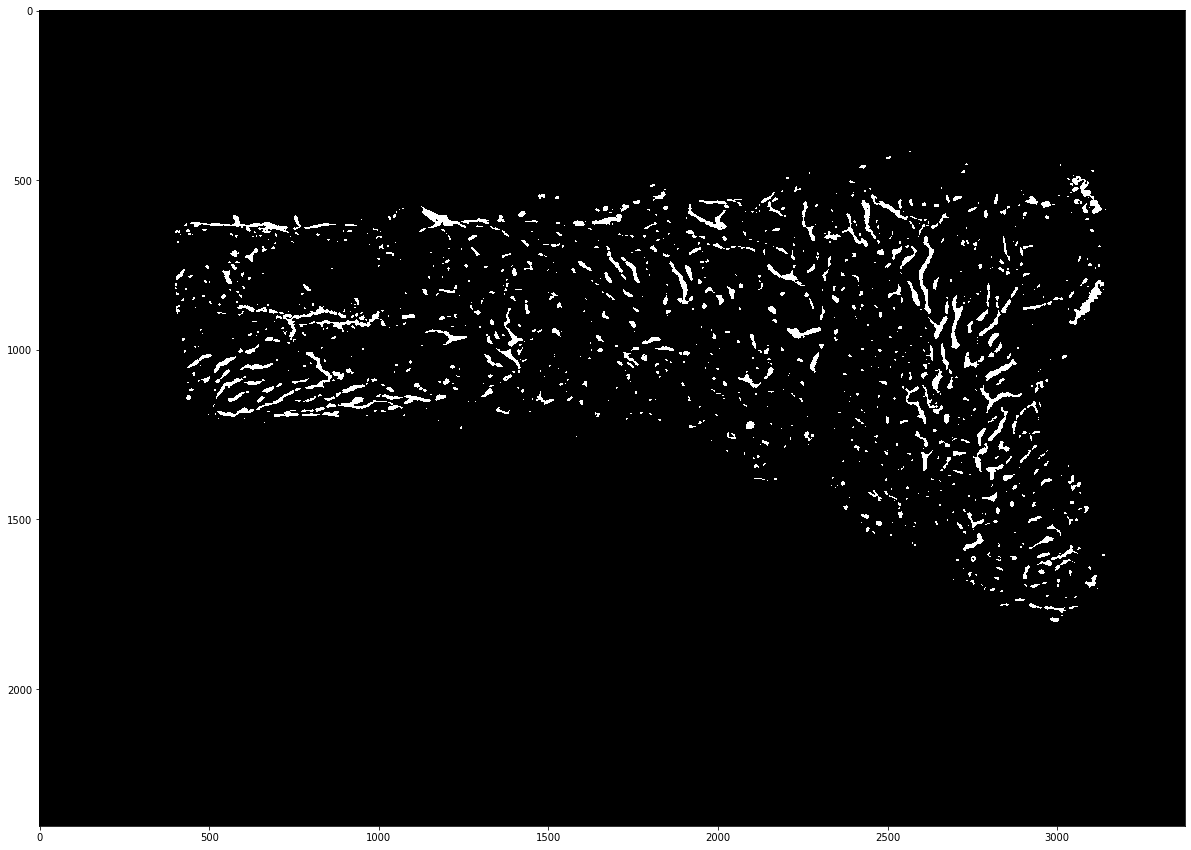

In [24]:
thresh2 = cle.threshold_otsu(backgrund_subtracted)

plt.figure(figsize=(30,15))
cle.imshow(thresh2[40])

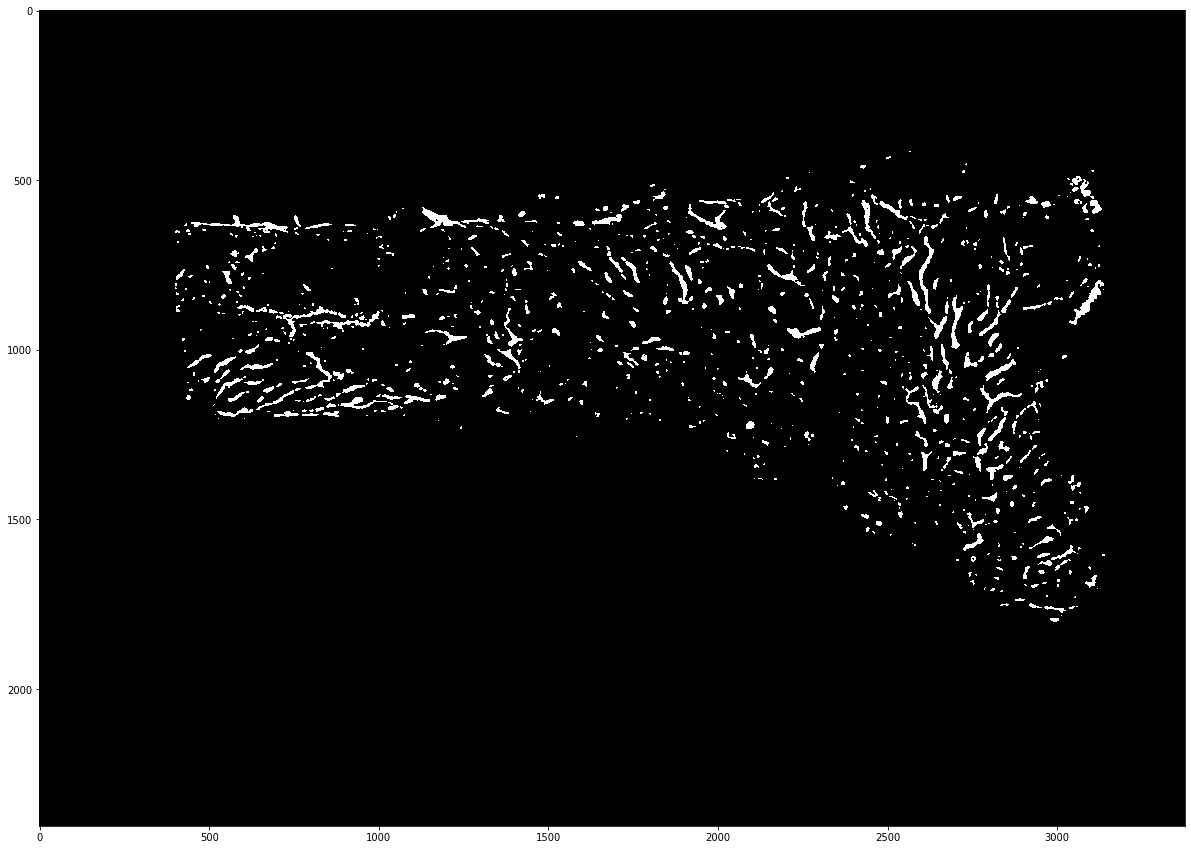

(76, 2404, 3376)


In [25]:
# Morphological opening
kernel = np.ones((5,5), np.uint8)
erosion = cle.erode_box(thresh2)
dilation = cle.dilate_box(erosion)

plt.figure(figsize=(30,15))
cle.imshow(dilation[40])
print(dilation.shape)

In [26]:
del erosion, thresh2, backgrund_subtracted, img_gaussian

(76, 2404, 3376)


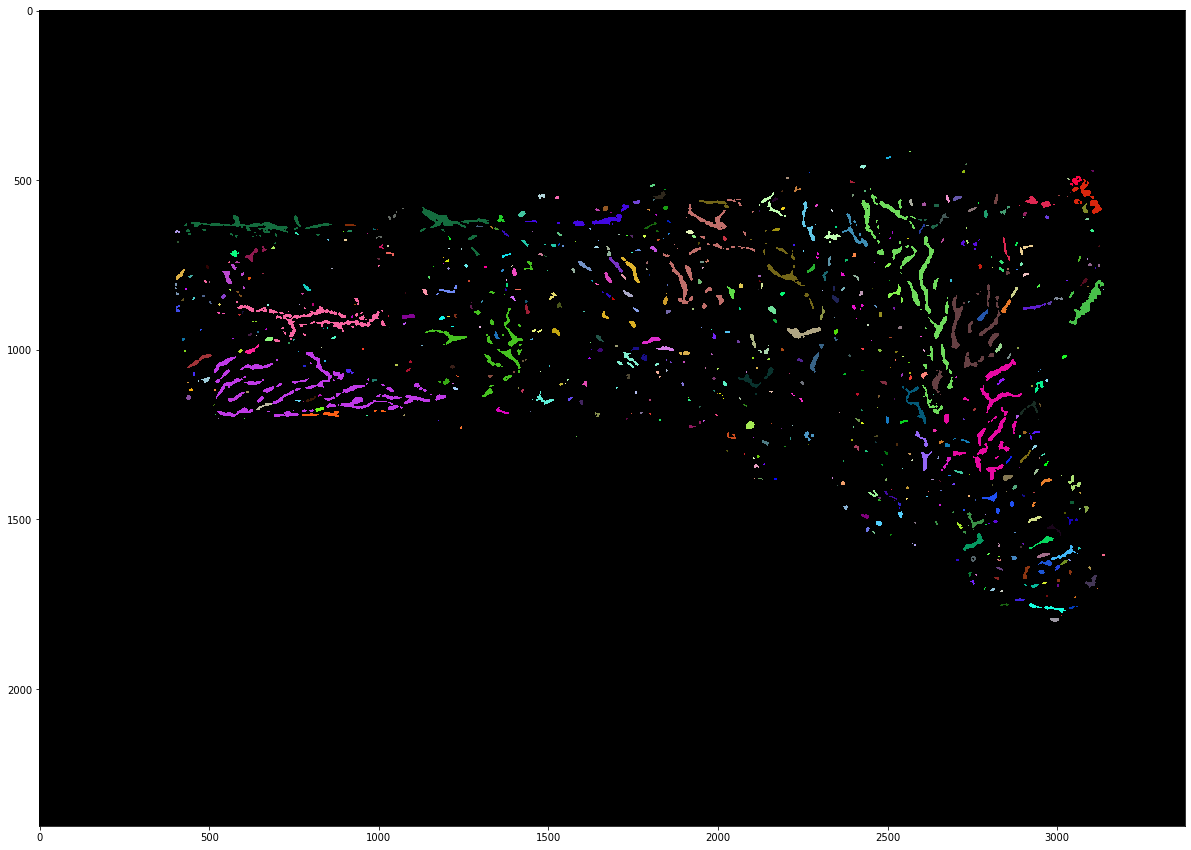

In [27]:
labels = cle.connected_components_labeling_box(dilation)
print(labels.shape)
plt.figure(figsize=(30,15))
cle.imshow(labels[40], labels=True)

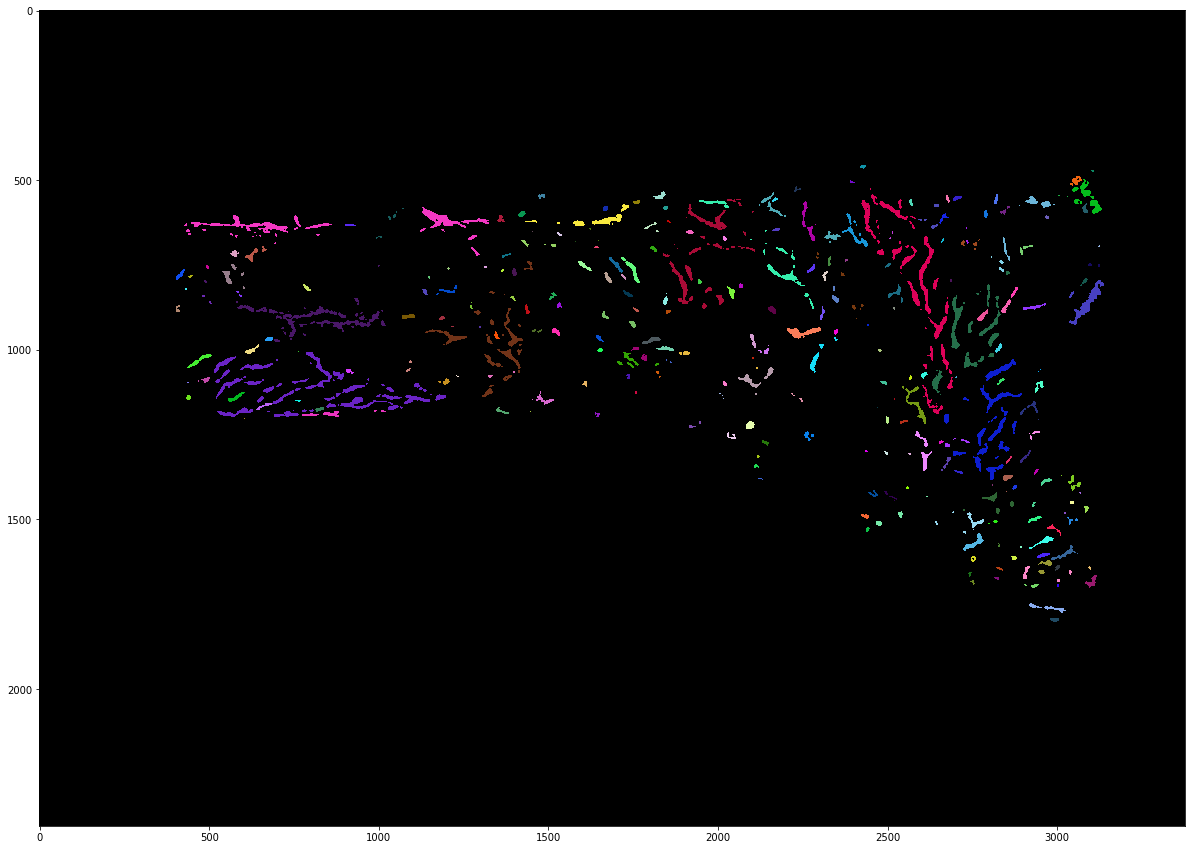

In [28]:
smalls_filtered_out = cle.exclude_labels_outside_size_range(labels, None, 2000, 1000000)
plt.figure(figsize=(30,15))
cle.imshow(smalls_filtered_out[40], labels=True)

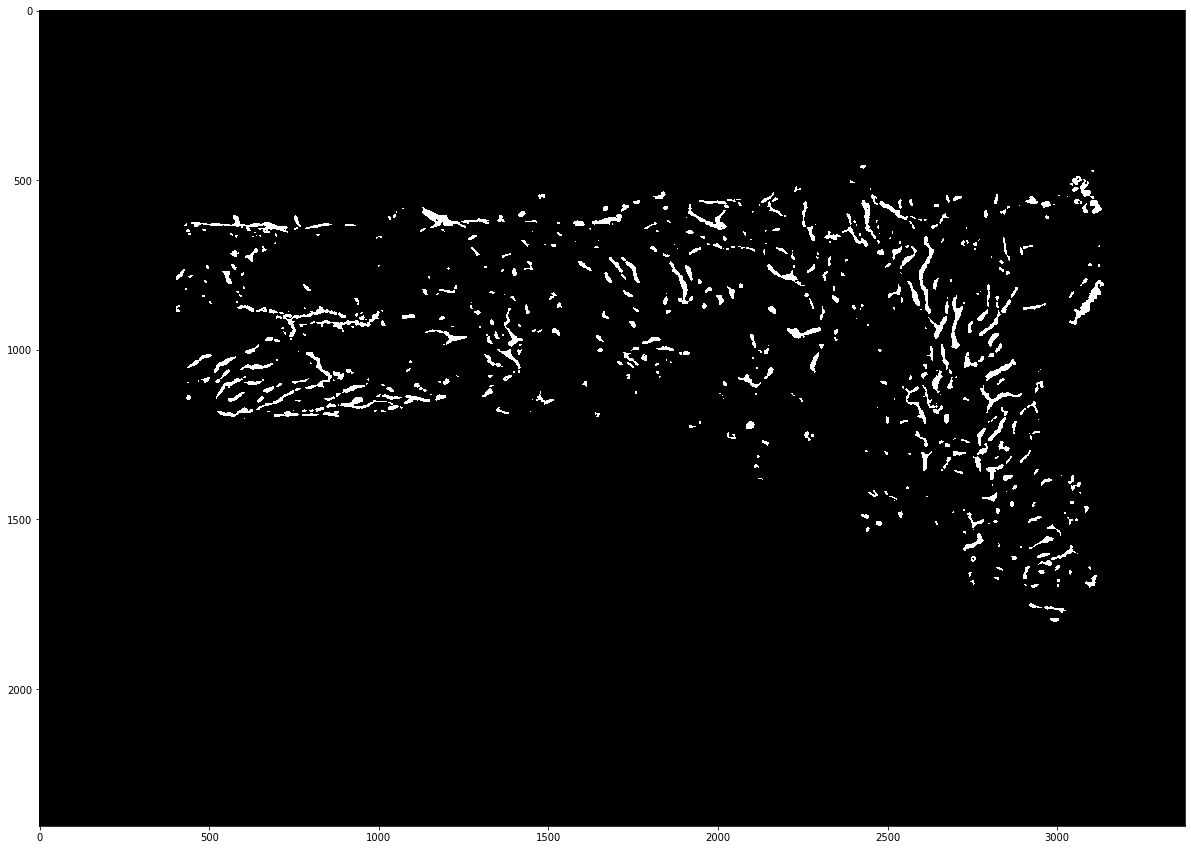

In [29]:
binarized_NG2 = 1 * (smalls_filtered_out > 0)
plt.figure(figsize=(30,15))
cle.imshow(binarized_NG2[40], labels=False)

In [30]:
print(np.unique(binarized_NG2))

total_image = np.concatenate((total_image, np.expand_dims(cle.pull(2000*binarized_NG2), axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

[0 1]
(7, 76, 2404, 3376)
uint16


[0 1]


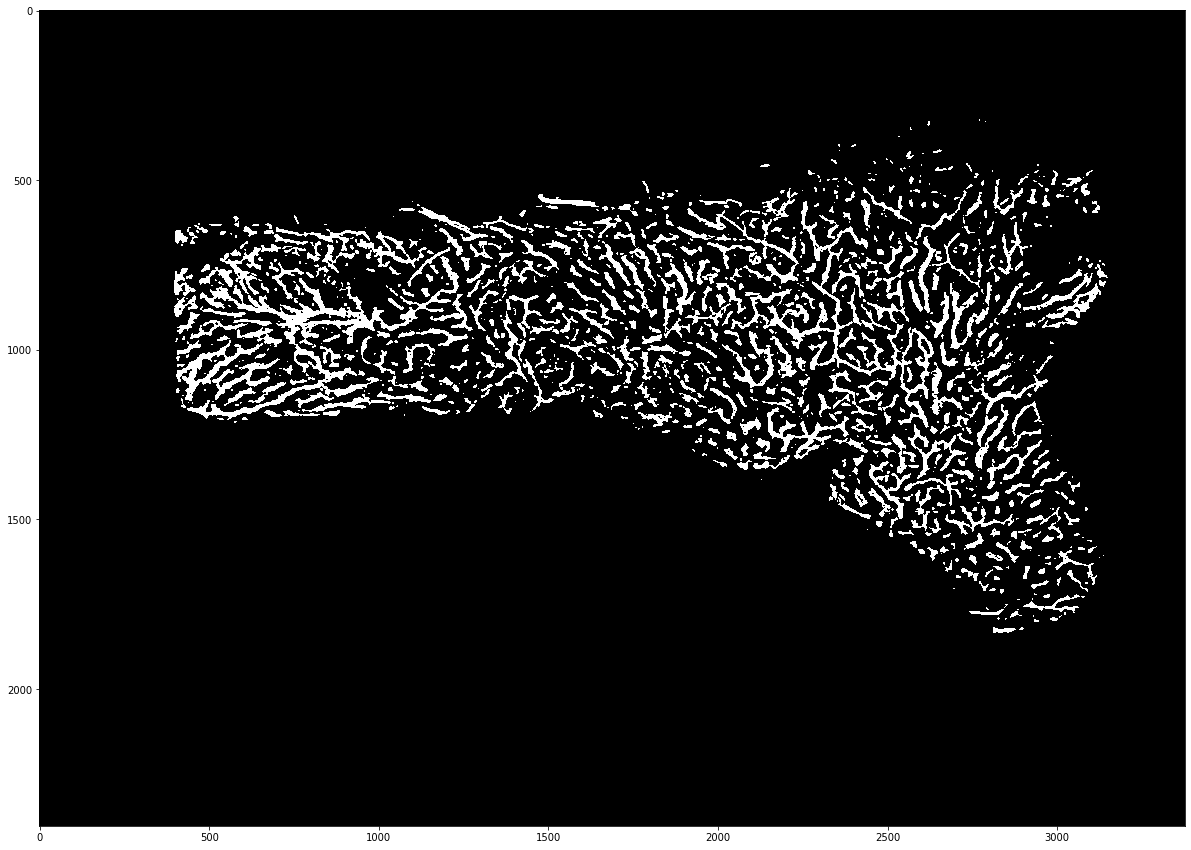

In [31]:
binarized_VESSEL = 1 * (total_image[4] > 0)
print(np.unique(binarized_VESSEL[40]))

plt.figure(figsize=(30,15))
cle.imshow(binarized_VESSEL[40], labels=False)

(76, 2404, 3376)


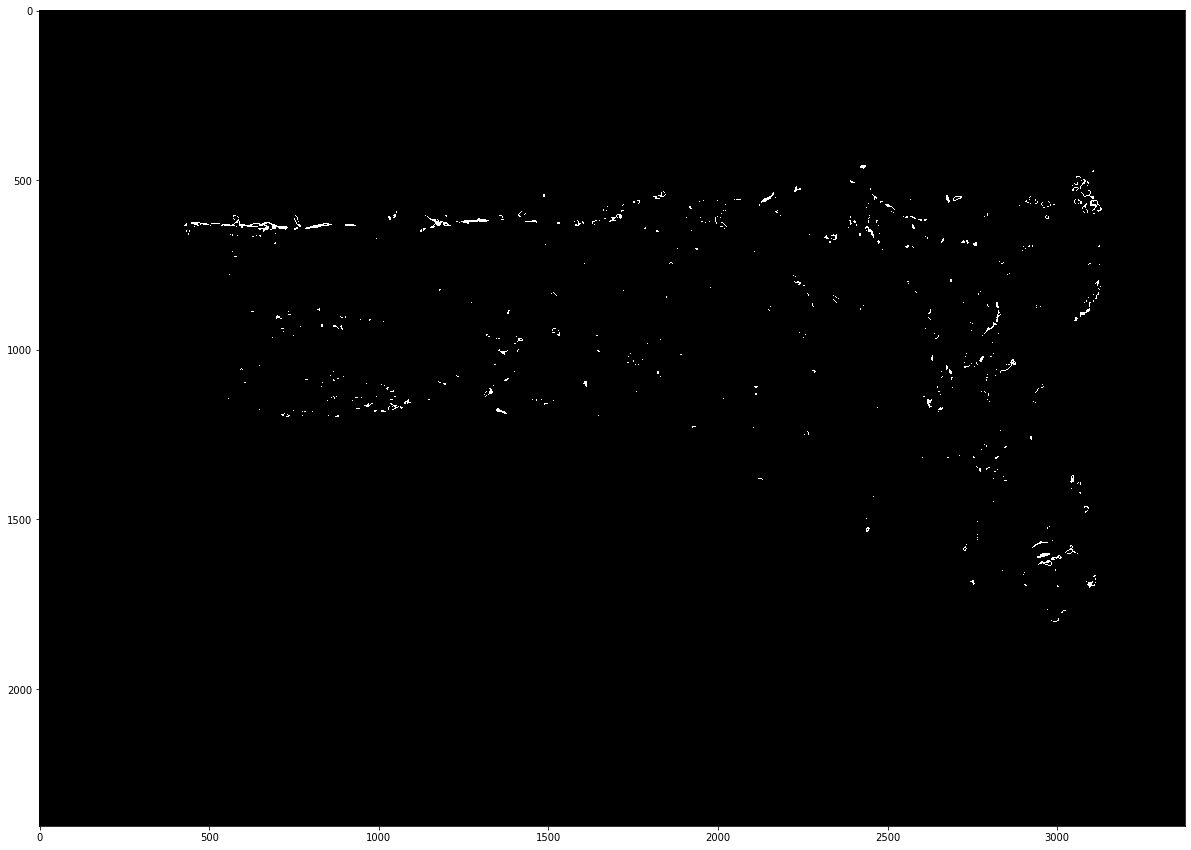

In [32]:
diff = binarized_NG2 - binarized_VESSEL
print(diff.shape)
diff = np.where(diff < 0, 0, diff)
np.unique(diff)
plt.figure(figsize=(30,15))
cle.imshow(diff[40], labels=False)

In [53]:
# Morphological opening
diff_erosion = cle.erode_box(diff)
diff_dilation = cle.dilate_box(diff_erosion)

plt.figure(figsize=(30,15))
cle.imshow(diff_dilation[40])
print(diff_dilation.shape)

NameError: name 'diff' is not defined

In [34]:
del diff_erosion, diff, binarized_VESSEL, binarized_NG2, labels, smalls_filtered_out

(76, 2404, 3376)


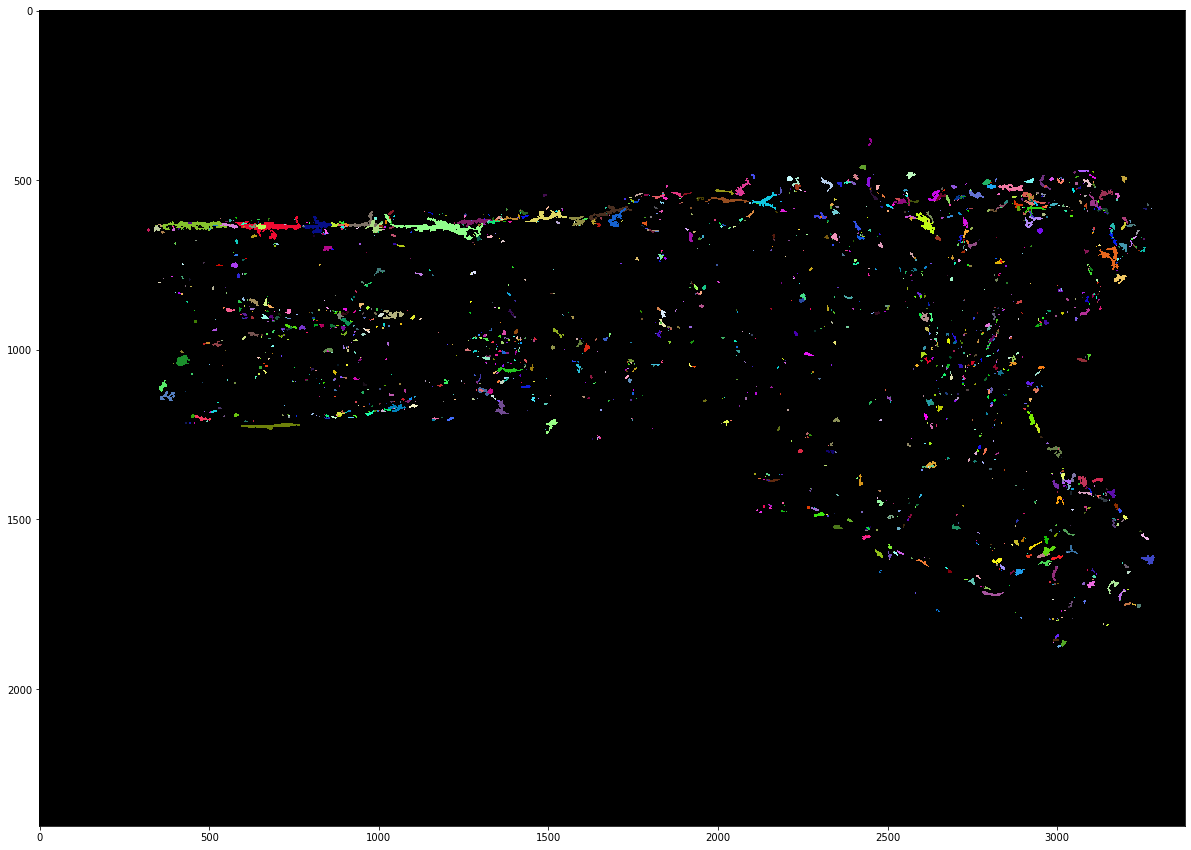

In [35]:
diff_labels = cle.connected_components_labeling_box(diff_dilation)
print(diff_labels.shape)
plt.figure(figsize=(30,15))
cle.imshow(diff_labels[40], labels=True)

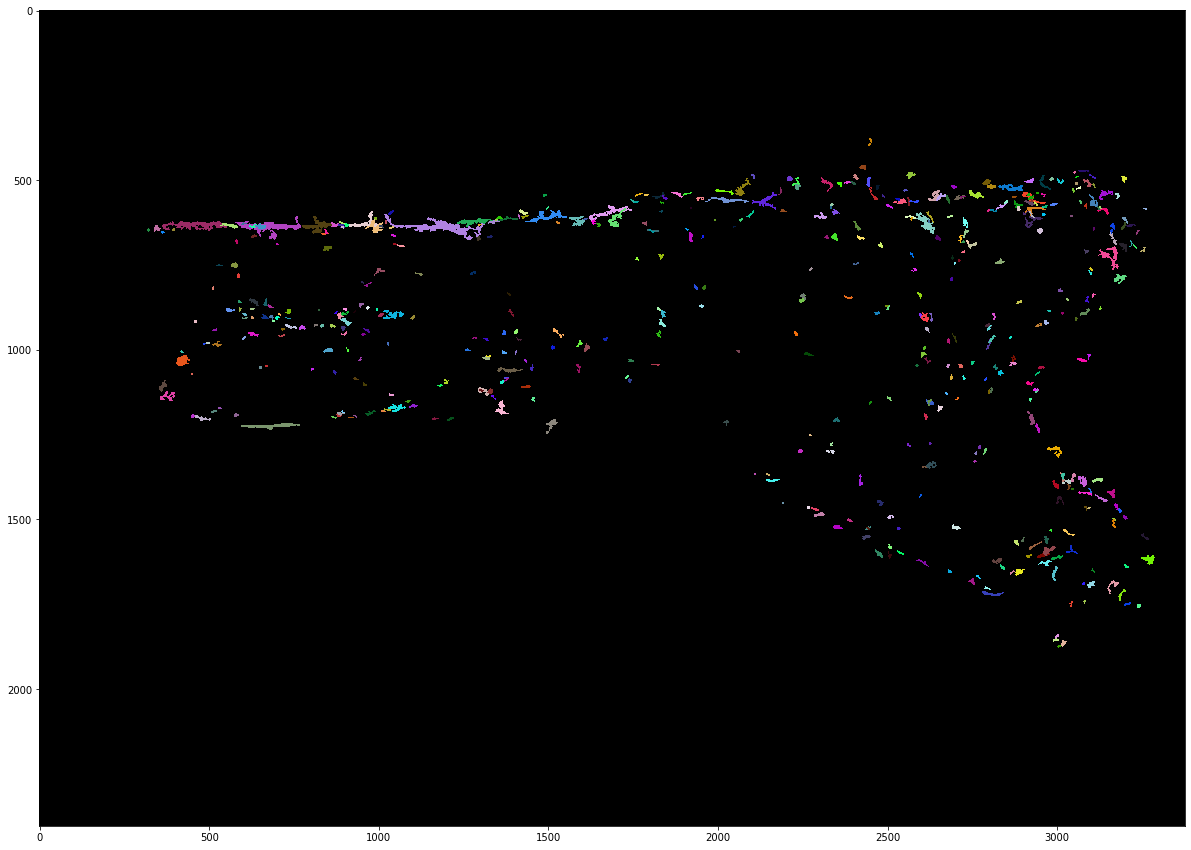

In [36]:
diff_smalls_filtered_out = cle.exclude_labels_outside_size_range(diff_labels, None, 256, 100000)
plt.figure(figsize=(30,15))
cle.imshow(diff_smalls_filtered_out, labels=True)

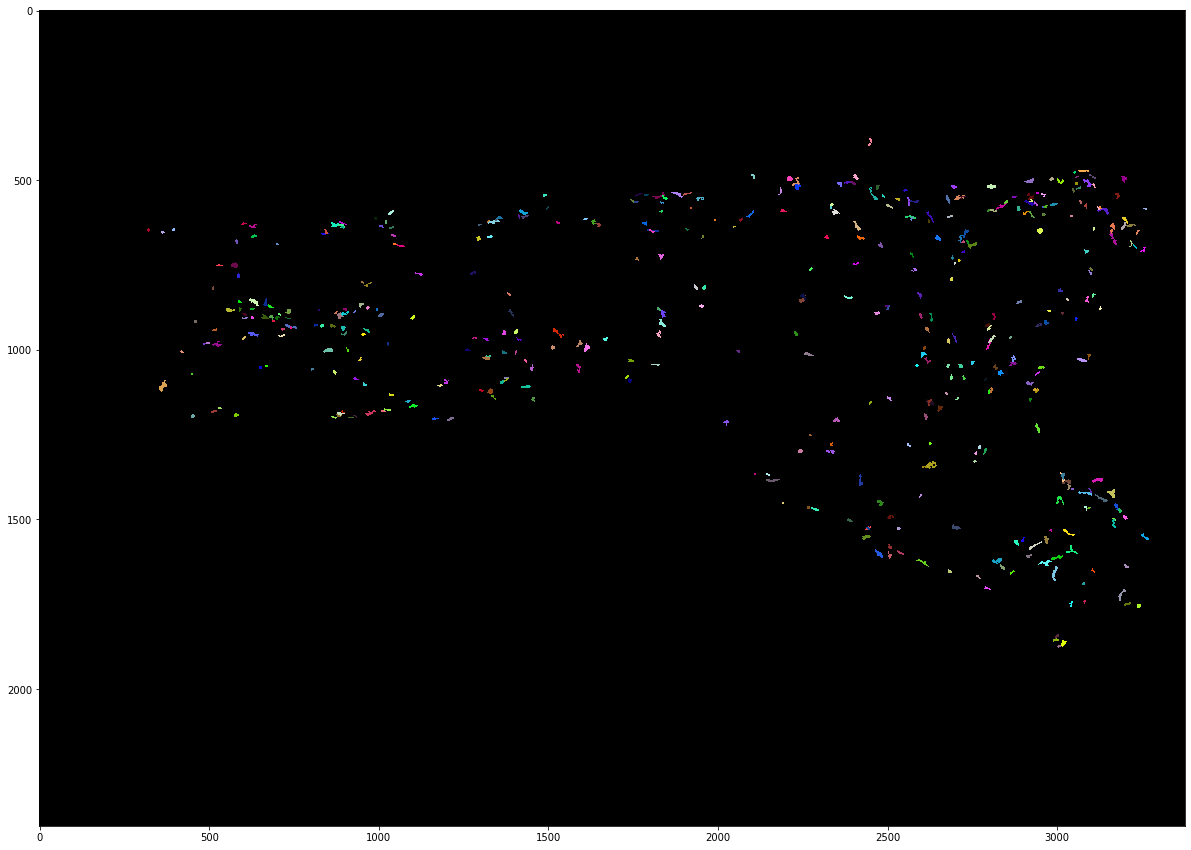

In [37]:
diff_smalls_filtered_out_x2 = cle.exclude_labels_outside_size_range(diff_labels, None, 256, 2000)
plt.figure(figsize=(30,15))
cle.imshow(diff_smalls_filtered_out_x2, labels=True)

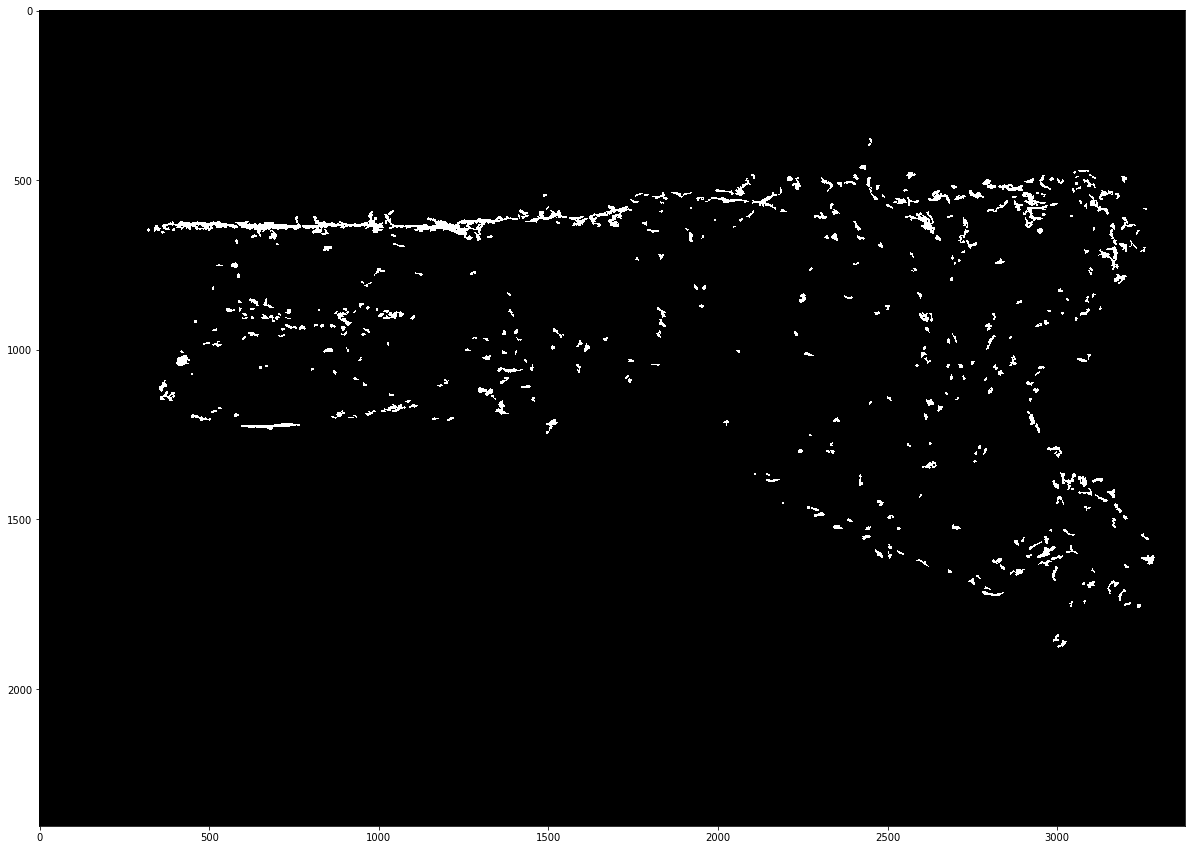

In [38]:
diff_binarized = 2000 * (diff_smalls_filtered_out > 0)
plt.figure(figsize=(30,15))
cle.imshow(diff_binarized, labels=False)

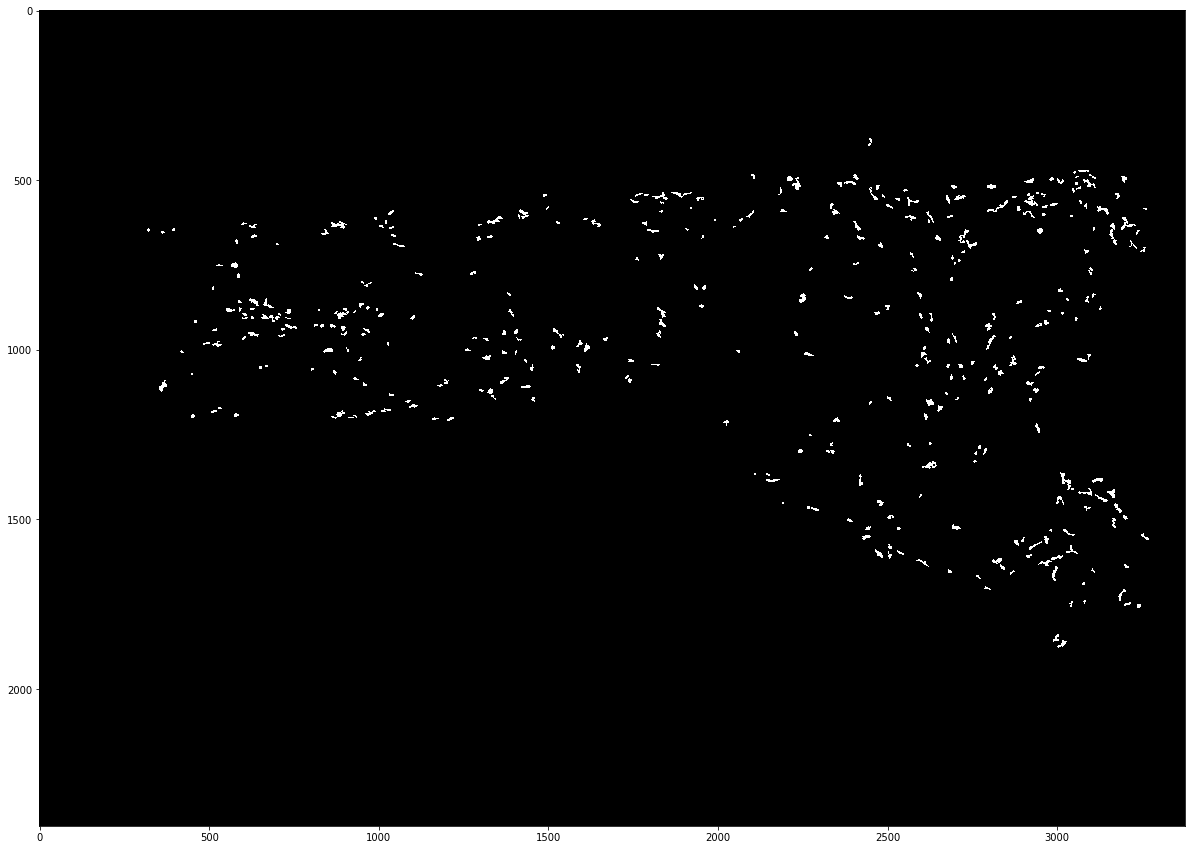

In [39]:
diff_binarized_x2 = 2000 * (diff_smalls_filtered_out_x2 > 0)
plt.figure(figsize=(30,15))
cle.imshow(diff_binarized_x2, labels=False)

In [40]:
total_image = np.concatenate((total_image, np.expand_dims(cle.pull(diff_binarized), axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

(8, 76, 2404, 3376)
uint16


In [41]:
total_image = np.concatenate((total_image, np.expand_dims(cle.pull(diff_binarized_x2), axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

(9, 76, 2404, 3376)
uint16


In [42]:
total_image = np.concatenate((total_image, np.expand_dims(mask, axis=0)), axis=0)
print(total_image.shape)
print(total_image.dtype)

(10, 76, 2404, 3376)
uint16


In [43]:
# viewer.save_as_tif_sequence(total_image, "/home/dkermany/data/Bone_Project/tif_sequences/FV10__20190620_111343/FV10__20190620_111343_10-channel")

Obtain distance mesh
----------------------------------

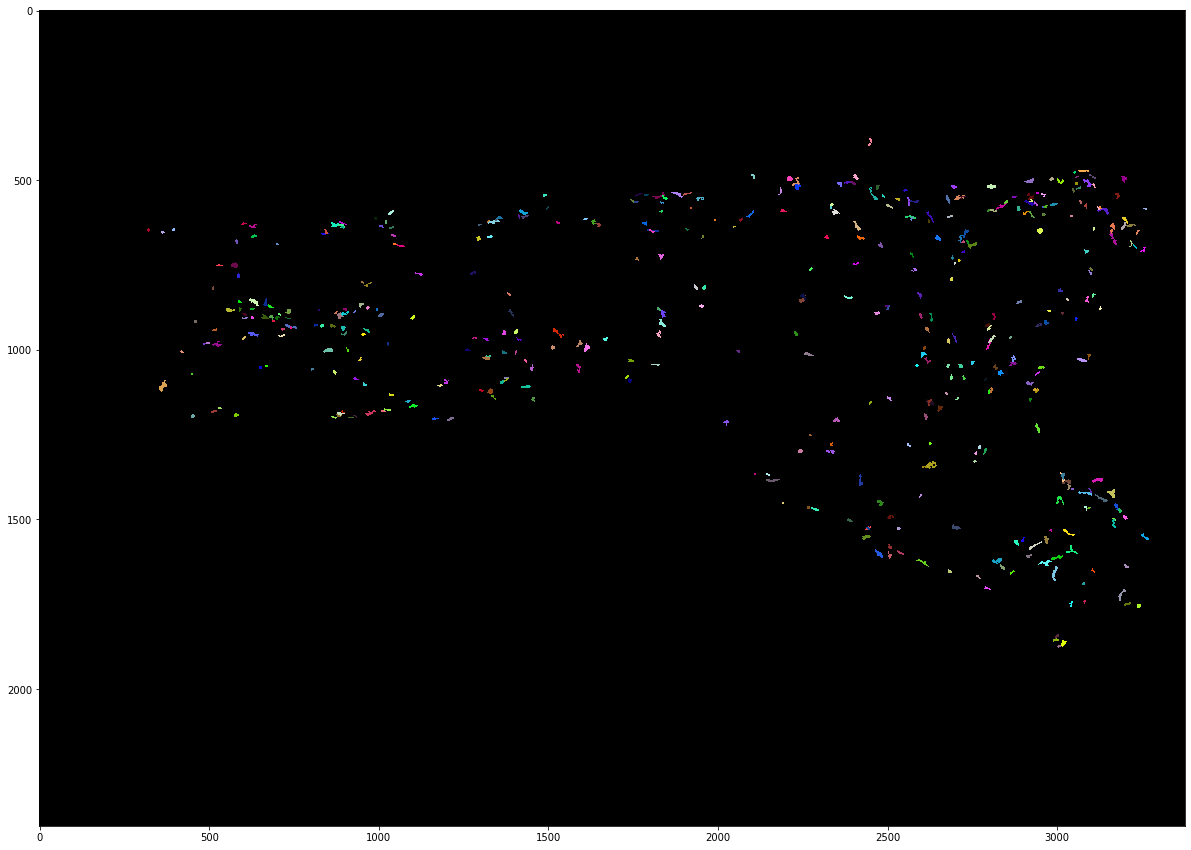

In [44]:
diff_smalls_filtered_out_x2.shape
plt.figure(figsize=(30,15))
cle.imshow(diff_smalls_filtered_out_x2, labels=True)

(76, 2404, 3376)


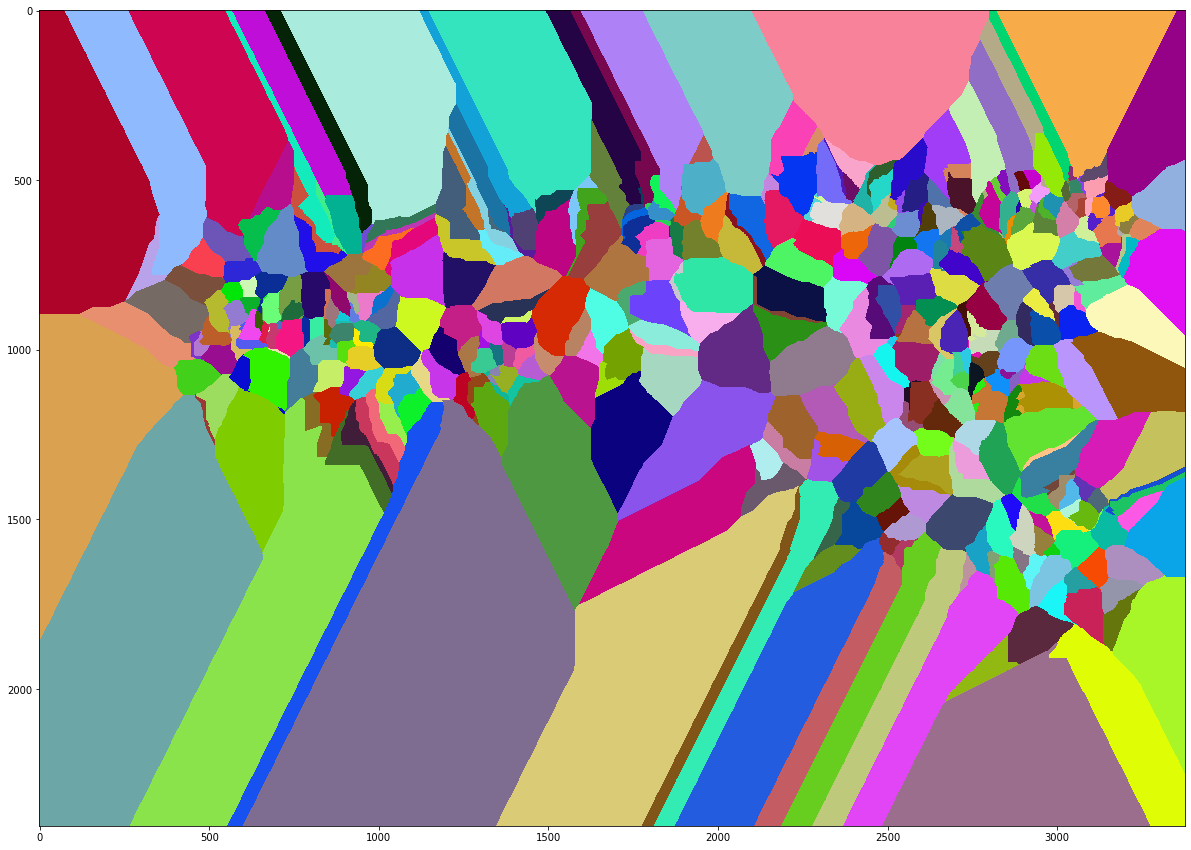

In [45]:
ng2_voronai = cle.extend_labeling_via_voronoi(diff_smalls_filtered_out_x2)
print(ng2_voronai.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_voronai, labels=True)

(440, 440)


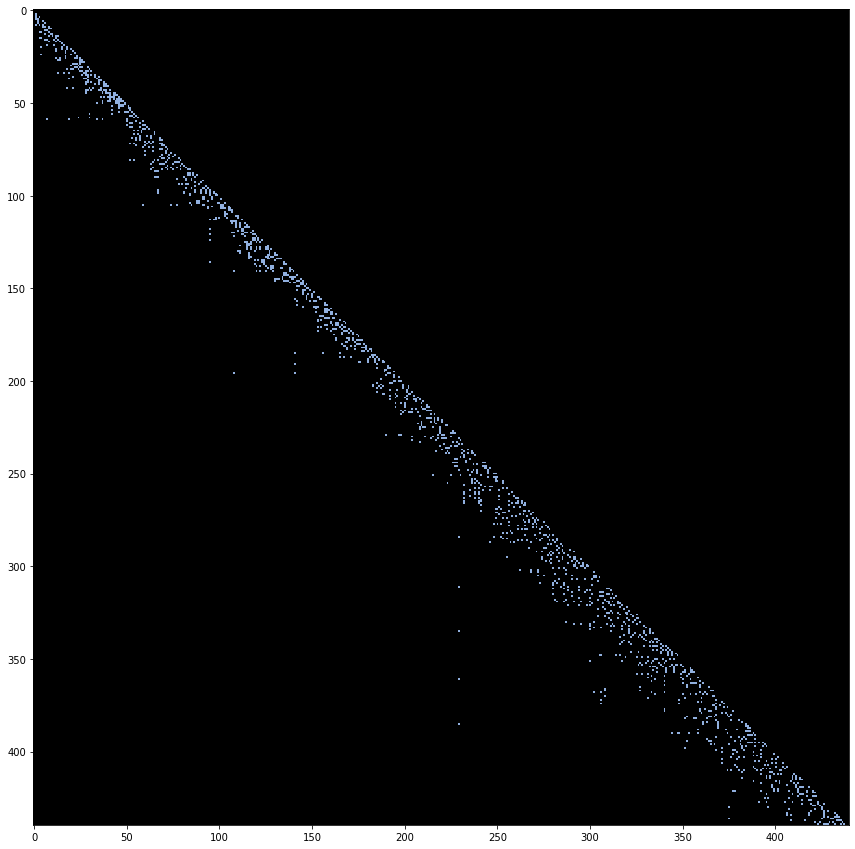

In [46]:
ng2_touch_matrix = cle.generate_touch_matrix(ng2_voronai)
print(ng2_touch_matrix.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_touch_matrix, labels=True)

In [47]:
ng2_centroids = cle.centroids_of_labels(diff_smalls_filtered_out_x2)
print(ng2_centroids.shape)
print(ng2_centroids)
print(type(ng2_centroids))

(3, 439)
[[3.2146835e+02 3.6559433e+02 3.6405130e+02 ... 3.2533035e+03
  3.2581887e+03 3.2593735e+03]
 [6.4767407e+02 1.1061930e+03 6.5434619e+02 ... 7.0484747e+02
  1.5531040e+03 5.8503229e+02]
 [4.8860760e+00 2.2335587e+00 2.8685899e+00 ... 6.3875786e+01
  7.3659607e+01 6.9231186e+01]]
<class 'pyclesperanto_prototype._tier0._pycl.OCLArray'>


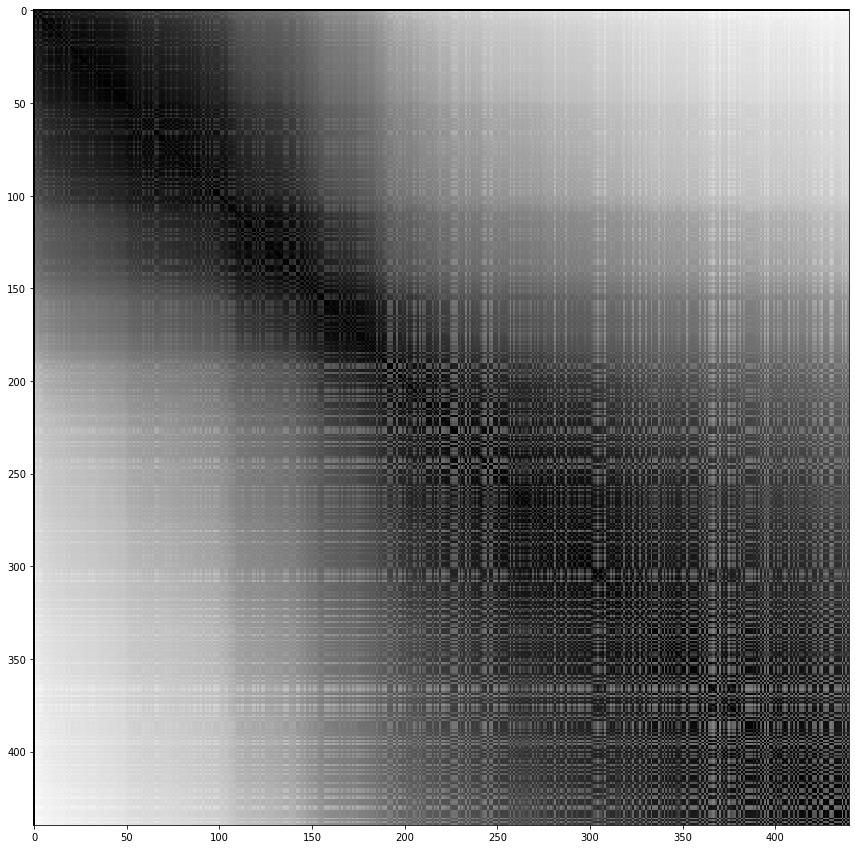

In [48]:
# NG2 distance matrix
ng2_distance_matrix = cle.generate_distance_matrix(ng2_centroids, ng2_centroids)

plt.figure(figsize=(30,15))
cle.imshow(ng2_distance_matrix, labels=False)

(440, 440)
(440, 440)


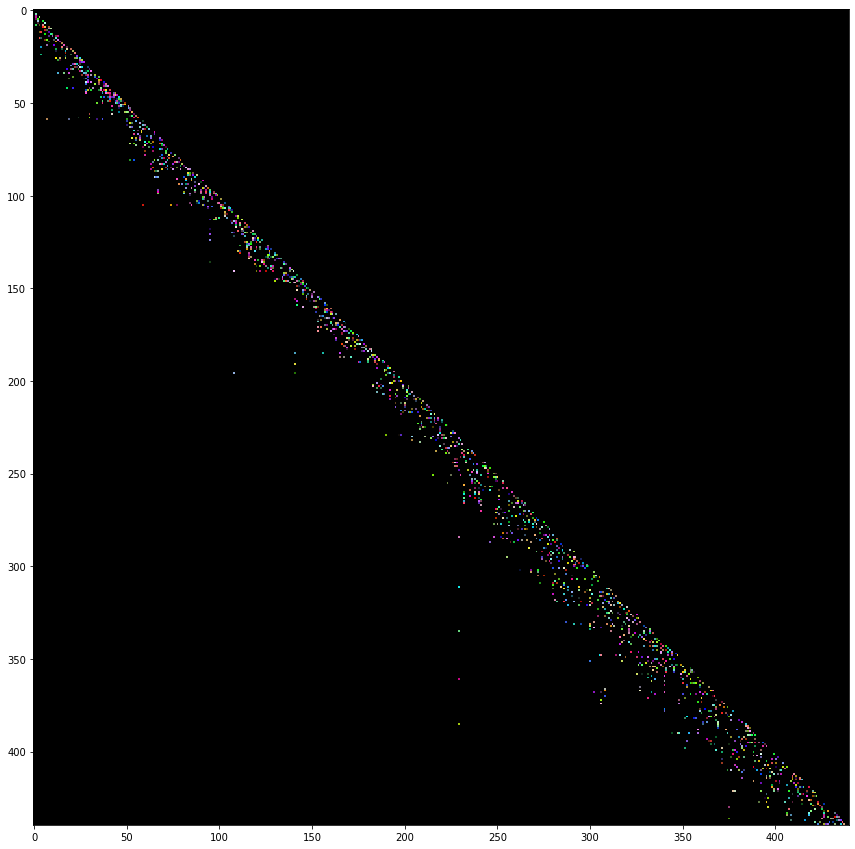

In [49]:
print(ng2_touch_matrix.shape)
print(ng2_distance_matrix.shape)

ng2_touch_distance_matrix = cle.multiply_images(ng2_touch_matrix, ng2_distance_matrix)
plt.figure(figsize=(30,15))
cle.imshow(ng2_touch_distance_matrix, labels=True)

(75, 1875, 3260)


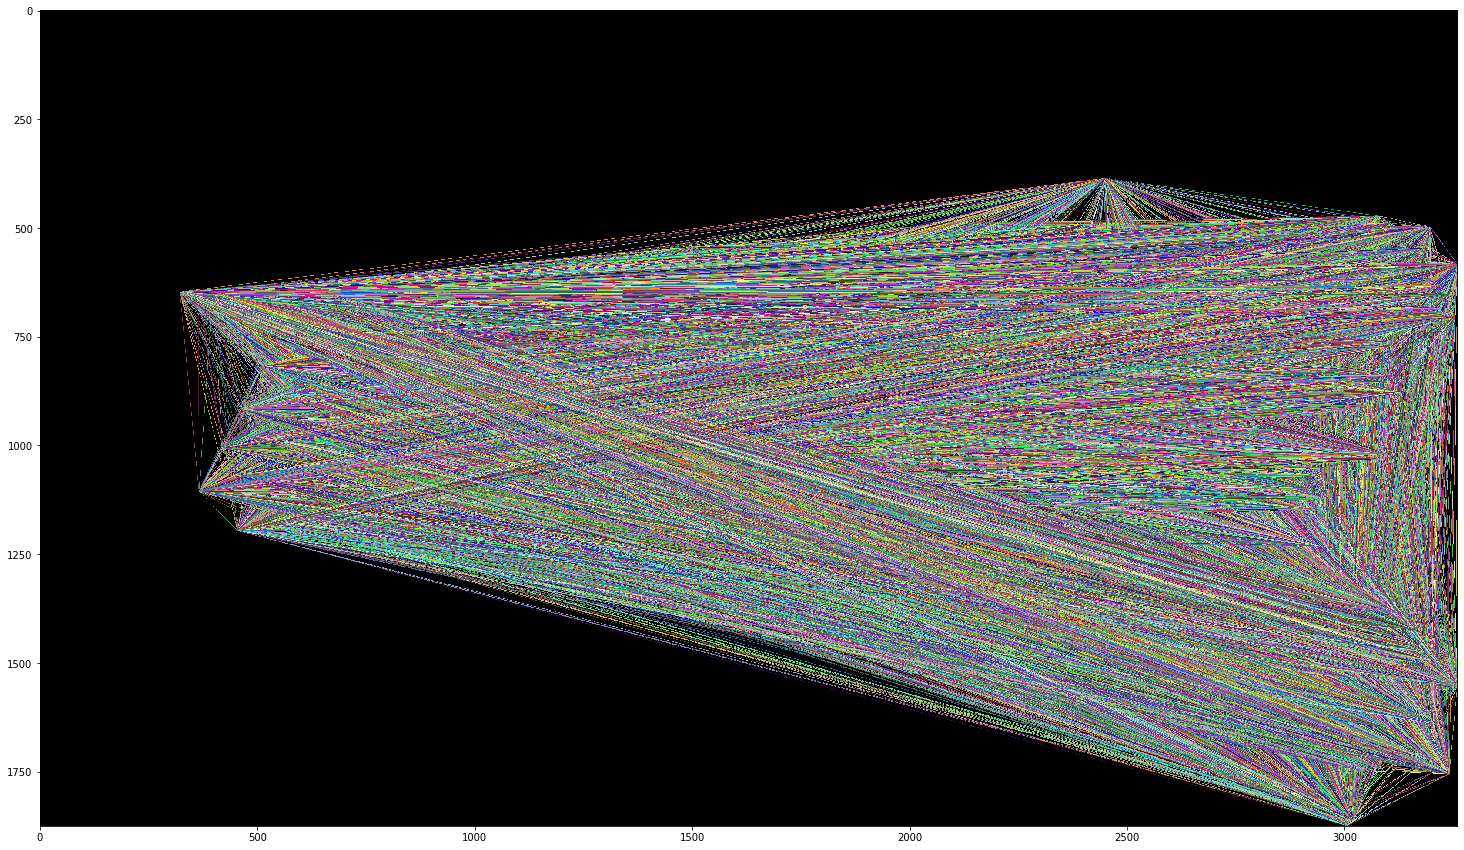

In [50]:
ng2_distance_mesh = cle.touch_matrix_to_mesh(ng2_centroids, ng2_distance_matrix)
print(ng2_distance_mesh.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_distance_mesh, labels=True)

(75, 1875, 3260)


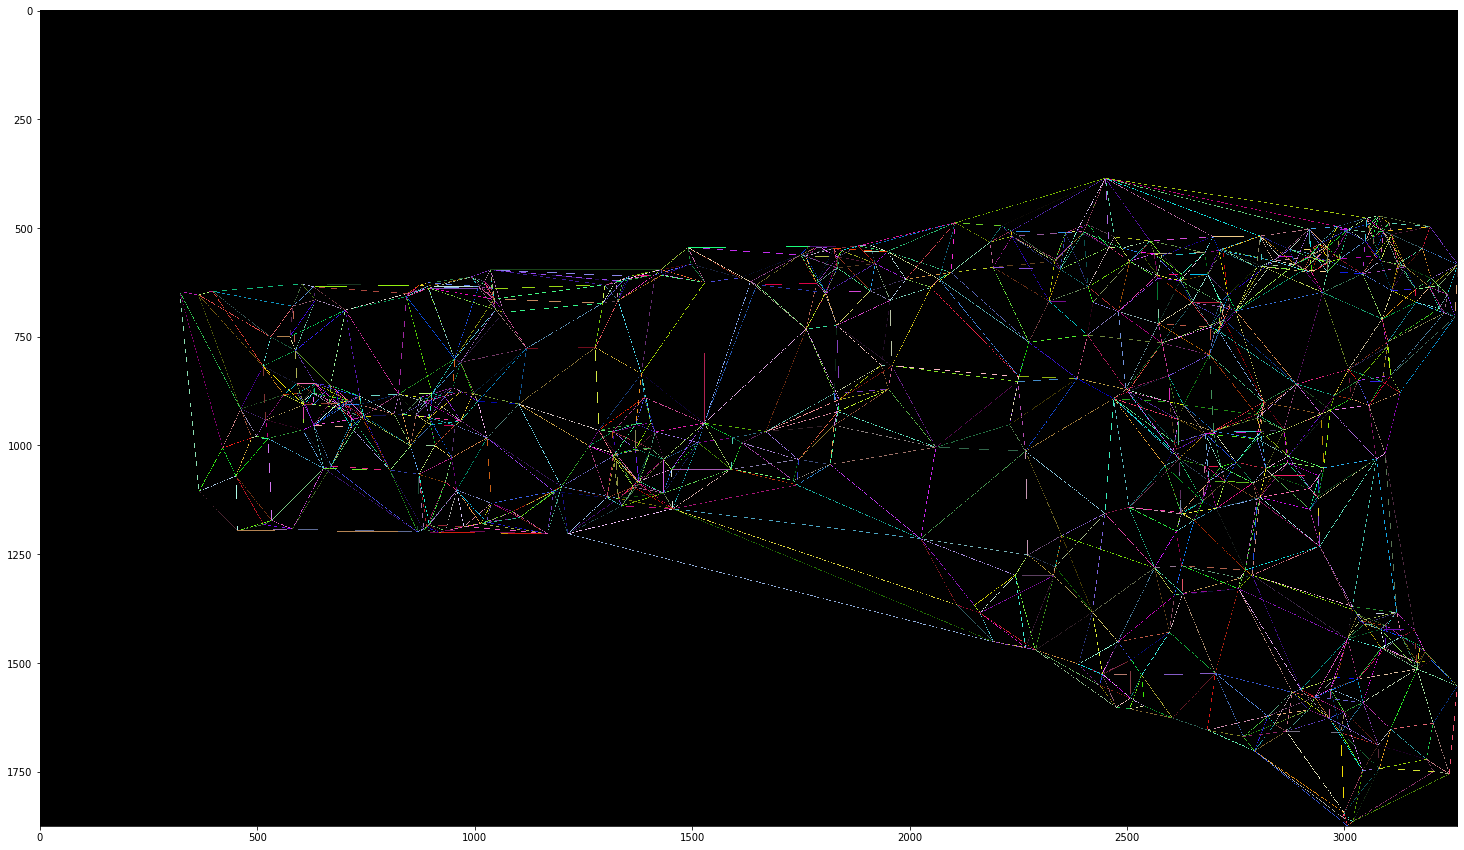

In [51]:
ng2_touch_mesh = cle.touch_matrix_to_mesh(ng2_centroids, ng2_touch_distance_matrix)
print(ng2_touch_mesh.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_touch_mesh, labels=True)

In [52]:
ng2_touch_distance_mesh = cle.touch_matrix_to_mesh(ng2_centroids, ng2_touch_distance_matrix)
print(ng2_touch_distance_mesh.shape)
plt.figure(figsize=(30,15))
cle.imshow(ng2_touch_distance_mesh, labels=True)

MemoryError: clEnqueueNDRangeKernel failed: MEM_OBJECT_ALLOCATION_FAILURE

DTC Distance Analyses
---

In [ ]:
# NG2-tumor distance matrix
tumor_distance_matrix = cle.generate_distance_matrix(tumor_pointlist, tumor_pointlist)
plt.figure(figsize=(30,15))
cle.imshow(tumor_distance_matrix, labels=True)

In [ ]:
tumor_distance_mesh = cle.touch_matrix_to_mesh(tumor_pointlist, tumor_distance_matrix)
plt.figure(figsize=(30,15))
cle.imshow(tumor_distance_mesh, labels=True)

In [ ]:
# create DTC voronai and filter connects using touching neighbors

In [ ]:
# filter connects by those within a certain distance (vs just touching neighbors)

In [ ]:
# 2D spatial distribution analyses